In [2]:
#%matplotlib notebook

import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
import joblib
from scipy.io import loadmat
from datetime import datetime
import time


# fix random seed for reproducibility
np.random.seed(7)
seed = 7


2023-12-29 16:06:41.470133: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 16:06:41.494224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 16:06:41.494246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 16:06:41.494261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 16:06:41.499079: I tensorflow/core/platform/cpu_feature_g

In [3]:
#utils - from circuit net.py

#------------------------------------
# Model definitons
#------------------------------------

def build_dense_model( dims, activation = 'sigmoid', l2_lambda = 0, loss='mean_squared_error'):
    """ 
    Builds the dense model and compiles it.
        
    Arguments:
    layer -- tuple with the number of nodes at each hidden layer. First number is the input size.
    activation = 'sigmoid' -- the activation to be used
    l2_lambda = 0 -- l2 with regularization lambda
    loss='mean_squared_error' -- loss to be used
    
    Returns:
    model -- the keras model
    
    """
    # SizingNet1-Single circuit model
    
    model = tf.keras.models.Sequential()
    level = 0 
    n_prev = dims[0]    
    for n_d in dims[1:]:
        if level == len(dims) - 2:
            activation = None
        model.add(tf.keras.layers.Dense(n_d, 
                        input_dim=n_prev, 
                        kernel_initializer='normal', 
                        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), 
                        activation=activation,
                        name='dense'+str(level) + '_' + str(n_d)))
        n_prev = n_d
        level = level + 1
    # Compile model
    model.compile(loss=loss,optimizer='adam',metrics=['mae', 'mse']) #recommended loss and optimizer 
                                                                        #functions for regression
    return model

## data scale functions
def scale_data(X, Y):
    """ 
        scales data and computes scaler
    """
    poly = PolynomialFeatures(2)
    X_scaler = StandardScaler()
    Y_scaler = MinMaxScaler(feature_range=(0.2, 0.8))
    
    
    X_poly = poly.fit_transform(X) #we now have a feature vector with 15 rows instead of only 4
    X_scaled = X_scaler.fit_transform(X_poly[:, 1:])
    
    Y_scaled = Y_scaler.fit_transform(Y)
    
    scaler_cache = {"X_poly": poly, "X_scaler": X_scaler, "Y_scaler": Y_scaler}
    
    return (X_scaled, Y_scaled, scaler_cache)

def unscale_Y(Y_scaled, scache):
    """ 
    Scales outputs to original values 
    """
    Y = scache["Y_scaler"].inverse_transform(Y_scaled)
    
    return Y

def scale_X(X, scache):
    """ Scales Inputs the same way as the training data """
    
    X_poly = scache["X_poly"].transform(X) #we now have a feature vector with 15 rows instead of only 4
    X_scaled = scache["X_scaler"].transform(X_poly[:, 1:])
    
    return X_scaled


def predict_circuit(X, model, scalers, scale_inputs=False):
    """ 
    Predict the circuit desing variables for given target specifications.
    
    Args:
    X -- a numpy 2D array with one target specification per row 
    model -- the trained model
    scalers -- the cache of scaller usef for pre-processing
    
    
    Returns the predicted desing variables.
    """
    
    if scale_inputs :
        X = scale_X(X, scalers)
        
    Y_pred = unscale_Y(model.predict(X), scalers)
    return Y_pred

# utils

def format_circuit(y, labels, minVal=None, maxVal=None):
    """ 
    Formats the desing variables in an aida friendly string. 
    
    Arguments:
    y -- a 2D numpy array with one solution per row
    lables -- a list of string with variables names in aida setup
    
    Returns -- dseing variables as a Stirng that AIDA can parse
    """
    s = ""
    n_r, n_c = y.shape
    if minVal is not None:
        y = np.clip(y, minVal, maxVal)

        
    for r in range(n_r):
        s += "Design Variables\n----\n"
        for l,c in zip(labels, range(n_c)):
            s += l + " = " + str(y[r][c]) + "\n"
        s+="----\n"
    return s

def show_history(history, metrics=['mean_absolute_error'], plot=True):
    """
    Prints the history
    
    Arguments:
    history -- the history as returned by model.fit
    """
    print('loss-train\t',history.history['loss'][-1])
    print('loss-val \t', history.history['val_loss'][-1])
    
    for metric in metrics:
        print(metric + '-train\t', history.history[metric][-1])
        print(metric + '-val \t', history.history['val_'+metric][-1])
    
    if not plot:
        return 
    # summarize history for loss
    plt.plot((history.history['loss']))
    plt.plot((history.history['val_loss']))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
        
    for metric in metrics:
        # summarize history for metric
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric])
        plt.title('model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
def format_data(y):
    """ 
    Formats the desing variables in an aida friendly string. 
    
    Arguments:
    y -- a 2D numpy array with one solution per row
    lables -- a list of string with variables names in aida setup
    
    Returns -- dseing variables as a Stirng that AIDA can parse
    """
    s = ""
    n_r, n_c = y.shape
            
    for r in range(n_r):
        for c in range(n_c):
            s += str(y[r][c]) + " "
        s+="\n"
    return s


def gnuplot_data(x, y, z, file):
    """ 
    Saves data for gnuplot. 
    
    Arguments:
    x,y,z -- numpy 1D arrays all of same size
    file  -- file name
    
    """
    s = ""
    n_r = len(y)
    
    with open(file, "w") as text_file:
        for r in range(n_r):
            print ("{:.3e} {:.3e} {:.3e}".format(x[r], y[r], z[r]), file=text_file)
    


[[1.e-13]]


KeyboardInterrupt: 

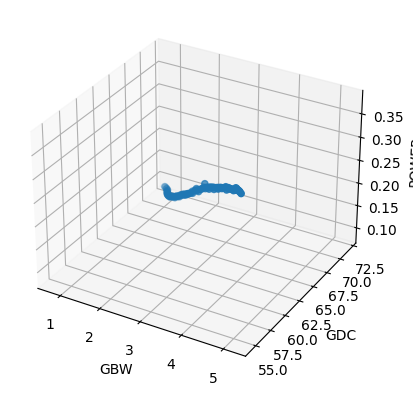

In [5]:
# data loading
from mpl_toolkits.mplot3d import Axes3D

GBW = 0
GDC = 1
PM  = 2
POWER = 3
CLOAD = 4

def load(c_value):
    data = loadmat('/media/ssd/Anot/MEEC/3 sem/PIC/Code/data/FCA/different Cload POFs_v2/Cload'+c_value+'00000e-13/matlab.mat')
    X = np.zeros((100, 5))
    Y = np.array(data['archive3d'])[:,:,-1]
    X[:,GBW] = np.array(data['archive_bw'])[-1,:]
    X[:,GDC] = np.array(data['archive_gain'])[-1,:]
    X[:,PM] = np.array(data['archive_pm'])[-1,:]
    X[:,POWER] = np.array(data['archive_power'])[-1,:]
    
    X[:,CLOAD] = data['Cload'][0,0]
    
    print(data['Cload'])
    return X,Y

c_values = ('1.0', '2.5', '3.5', '4.5') 

X = np.zeros((100*len(c_values), 5))
Y = np.zeros((100*len(c_values), 19))



fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('GBW')
ax.set_ylabel('GDC')
ax.set_zlabel('POWER')

for cval,i in zip(c_values, range(len(c_values))):
    X[i*100:i*100 + 100,:],Y[i*100:i*100 + 100,:] = load(cval)
    ax.scatter(X[i*100:i*100 + 100,GBW], X[i*100:i*100 + 100,GDC], X[i*100:i*100 + 100,POWER]*1000, label=cval)

fig.legend()
plt.show()




In [ ]:
# Scale data 
X_scaled, Y_scaled, scalers = scale_data(X, Y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled,
                                                    test_size = 0.2,
                                                    random_state = seed)

print("X")
print(X.max(axis=0))
print(X.min(axis=0))

print("X_scaled")
print(X_scaled.max(axis=0))
print(X_scaled.min(axis=0))

print("Y_scaled")
print(Y_scaled.max(axis=0))
print(Y_scaled.min(axis=0))

print(X.shape)
print(Y.shape)
print(X_train.shape)
print(X_test.shape)



X
[5.19525700e+08 7.98795000e+01 5.68058556e+01 4.23222000e-04
 4.50000000e-13]
[1.88099100e+07 5.45773300e+01 4.50026288e+01 4.79885900e-05
 1.00000000e-13]
X_scaled
[2.9360557  2.01156517 6.85372946 2.17539345 1.25675744 3.87523409
 2.56541683 2.84277816 3.24589369 2.92393929 2.17357209 4.0575665
 2.27310172 1.60117848 7.07719364 3.13785547 2.02091032 2.69202369
 2.70692405 1.43990899]
[-1.76058202 -2.44676577 -0.45665019 -2.27198858 -1.45010473 -0.96313751
 -2.09035842 -1.72514676 -1.28245403 -1.74481207 -2.27753284 -2.47527545
 -2.44310738 -1.49769489 -0.43452064 -2.08110434 -1.42591696 -1.46319681
 -1.37424368 -1.24792113]
Y_scaled
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8]
[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2]
(400, 5)
(400, 19)
(320, 20)
(80, 20)


train --- 0.03290224075317383 seconds ---
[[1.5e-13]]
[[4.e-13]]
[[5.e-13]]
prediction --- 0.403658390045166 seconds ---


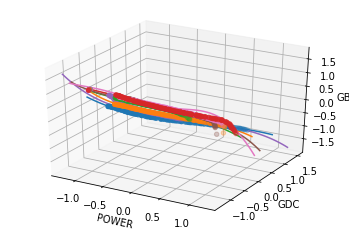

In [ ]:
# Performance models on scaled data
#%matplotlib notebook
from sklearn.linear_model import Ridge
from collections import namedtuple

# saves as a named touple
perf_model = {}

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('POWER')
ax.set_ylabel('GDC')
ax.set_zlabel('GBW')


start_time = time.time()

# generate points used to plot
performance_scaler = MinMaxScaler((-1.0, 1.0))
perf_X_scaled = performance_scaler.fit_transform(X[:,0:4])
degree = 5

x_plot = np.linspace(-1.0, 1.0, 100)
poly_x_plot = PolynomialFeatures(degree, ).fit_transform(x_plot[:, np.newaxis])



#used to store model coefs that will be fitted
c_fit = np.zeros((len(c_values), 1 ))
coefs_fit = np.zeros((len(c_values), (degree + 1)*3 ))

unfit_coef_shape = None

for cval,i in zip(c_values, range(len(c_values))):
    perf_X  = perf_X_scaled[i*100:i*100 + 100,POWER]
    perf_F1 = perf_X_scaled[i*100:i*100 + 100,GBW]
    perf_F2 = perf_X_scaled[i*100:i*100 + 100,GDC]
    perf_F3 = perf_X_scaled[i*100:i*100 + 100,PM]
   
  
    perf_F = np.hstack([perf_F1[:, np.newaxis], perf_F2[:, np.newaxis], perf_F3[:, np.newaxis]])

    poly_perf_X = PolynomialFeatures(degree).fit_transform(perf_X[:, np.newaxis])
    
    model_F = Ridge(alpha=0.2, fit_intercept = False)
    model_F.fit(poly_perf_X, perf_F)
    f_plot = model_F.predict(poly_x_plot)
    
    
    perf_model[cval] = model_F
    c_fit[i,0] = float(cval)
    unfit_coef_shape = perf_model[cval].coef_.shape
    coefs_fit[i,:] = np.reshape(perf_model[cval].coef_, -1)
    
    
    ax.plot(x_plot, f_plot[:,0], f_plot[:,1])
    ax.scatter(perf_X, perf_F1, perf_F2, label=cval)
    gnuplot_data(x_plot, f_plot[:,0], f_plot[:,1], "fit_"+cval+".dat")
    gnuplot_data(perf_X, perf_F1, perf_F2, "original_"+cval+".dat")
    
PerformanceModel = namedtuple("PerformanceModel", ["cvalues", "c_scaler", "coef_scaler", "perf_scaler", "F"])

c_scaler   = MinMaxScaler((-1, 1))
coef_scaler  = MinMaxScaler((-1, 1)) 
                 
c_fit = c_scaler.fit_transform(c_fit)
c_fit_poly = PolynomialFeatures(3).fit_transform(c_fit)                 
                 
coefs_fit = coef_scaler.fit_transform(coefs_fit)

model_cvar = Ridge(alpha=0.1, fit_intercept = False)
model_cvar.fit(c_fit_poly, coefs_fit)

perf_model['varc'] = PerformanceModel(c_values, c_scaler, coef_scaler, performance_scaler, model_cvar)

# make a pof prediction for 4
print("train --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

c_target_list = (1.5, 4.0,5.0)
x_plot = np.linspace(-1.25, 1.25, 100)
poly_x_plot = PolynomialFeatures(degree, ).fit_transform(x_plot[:, np.newaxis])
estimated_pof = {}

for c_target in c_target_list:
    cload_target = perf_model['varc'].c_scaler.transform(np.array([[c_target]]))
    poly_cload_target = np.array([[1, cload_target, cload_target*cload_target, cload_target*cload_target*cload_target]])

    cload_target_coefs = perf_model['varc'].coef_scaler.inverse_transform(perf_model['varc'].F.predict(poly_cload_target))
    cload_target_coefs = np.reshape(cload_target_coefs, unfit_coef_shape)


    f_target_plot = np.matmul(poly_x_plot, cload_target_coefs.transpose())

    
    Xuse, Yuse = load(str(c_target))
    Xuse = performance_scaler.transform(Xuse[:,0:4])
    
    
    ax.plot(x_plot, f_target_plot[:,0], f_target_plot[:,1], label='guess ' + str(c_target))
    ax.scatter(Xuse[:,POWER], Xuse[:,GBW], Xuse[:,GDC], label='original ' + str(c_target))
    gnuplot_data(x_plot, f_target_plot[:,0], f_target_plot[:,1], "guess_"+str(c_target)+".dat")
    gnuplot_data(Xuse[:,POWER], Xuse[:,GBW], Xuse[:,GDC], "original_"+str(c_target)+".dat")

    ## used to predic sizing

    x_plot_ = x_plot[:, np.newaxis]

    estimated_pof[str(c_target)] = performance_scaler.inverse_transform(np.hstack([f_target_plot, x_plot_]))

    estimated_pof[str(c_target)] = np.hstack([estimated_pof[str(c_target)], np.ones(x_plot_.shape)*c_target*1e-13])

    
    #with open("/home/aida/Documents/Plots/2019-SMACD/estimate_wide_"+str(c_target)+".dat", "w") as text_file:
    #    print(format_data(estimated_pof[str(c_target)]), file=text_file)
    
print("prediction --- %s seconds ---" % (time.time() - start_time))    


#fig.legend()
#plt.show()

In [ ]:
#high level tensorflow
np.random.seed(7)

CSP = {}

CSP['large'] = build_dense_model((20, 480, 240, 60, 19), activation='relu', l2_lambda=0.0001)
CSP['medium'] = build_dense_model((20, 200, 100, 19), activation='relu', l2_lambda=0.0001)
CSP['small'] = build_dense_model((20, 100, 19), activation='relu', l2_lambda=0.0001)
CSP['very small'] = build_dense_model((20, 50, 19), activation='relu', l2_lambda=0.0001)


In [ ]:
#Starting Time
history_64 = {}

for key, model in CSP.items():
    start_time = time.time()
    history_64[key] = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 1000, 
                    batch_size= 64, 
                    verbose = 0)
    print("ANN train --- %s seconds ---" % (time.time() - start_time))  
    
    print(key)
    show_history(history_64[key], plot=False)


ANN train --- 23.11963129043579 seconds ---
large
loss-train	 0.0014519722433760762
loss-val 	 0.0015007576905190945
mean_absolute_error-train	 0.011021948233246804
mean_absolute_error-val 	 0.01273461189121008
ANN train --- 12.733714580535889 seconds ---
medium
loss-train	 0.0010885985800996422
loss-val 	 0.0011222195811569692
mean_absolute_error-train	 0.009616302326321602
mean_absolute_error-val 	 0.010614672303199768
ANN train --- 8.742982149124146 seconds ---
small
loss-train	 0.0007590984227135777
loss-val 	 0.0007771458942443133
mean_absolute_error-train	 0.00876410249620676
mean_absolute_error-val 	 0.009401710517704488
ANN train --- 8.305278062820435 seconds ---
very small
loss-train	 0.0007905033067800105
loss-val 	 0.0008000077563337981
mean_absolute_error-train	 0.008818292990326881
mean_absolute_error-val 	 0.009020541049540042


In [ ]:
show_history(history_64['small'], metrics=['mean_absolute_error', 'mean_squared_error'], plot=False)

loss-train	 0.0007590984227135777
loss-val 	 0.0007771458942443133
mean_absolute_error-train	 0.00876410249620676
mean_absolute_error-val 	 0.009401710517704488
mean_squared_error-train	 0.00021499738504644484
mean_squared_error-val 	 0.00023353692959062755


In [ ]:
#Starting Time
history_256 = {}

for key, model in CSP.items():
    print(key)
    start_time = time.time()
    history_256[key] = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test,y_test),
                    epochs = 1000, 
                    batch_size= 256, 
                    verbose = 0)
    print("ANN train --- %s seconds ---" % (time.time() - start_time))  
    
    show_history(history_256[key], plot=False)

large
ANN train --- 12.329288721084595 seconds ---
loss-train	 0.0013223986374214292
loss-val 	 0.0013551118317991495
mean_absolute_error-train	 0.009397172182798386
mean_absolute_error-val 	 0.010346852242946625
medium
ANN train --- 6.437291383743286 seconds ---
loss-train	 0.0010308863129466772
loss-val 	 0.0010684534208849072
mean_absolute_error-train	 0.00893260706216097
mean_absolute_error-val 	 0.01010497659444809
small
ANN train --- 3.905884265899658 seconds ---
loss-train	 0.0007195611600764096
loss-val 	 0.0007415515137836337
mean_absolute_error-train	 0.008073092065751552
mean_absolute_error-val 	 0.008393710479140282
very small
ANN train --- 3.6035664081573486 seconds ---
loss-train	 0.0007326515624299645
loss-val 	 0.0007499235798604786
mean_absolute_error-train	 0.008167394995689392
mean_absolute_error-val 	 0.008505905978381634


In [ ]:
show_history(history_256['small'], metrics=['mean_absolute_error', 'mean_squared_error'], plot=False)


loss-train	 0.0007195611600764096
loss-val 	 0.0007415515137836337
mean_absolute_error-train	 0.008073092065751552
mean_absolute_error-val 	 0.008393710479140282
mean_squared_error-train	 0.00019778635469265283
mean_squared_error-val 	 0.0002199547307100147


In [ ]:
# Save model
date_str = '{:%Y%m%d%H%M}'.format(datetime.now())

CSP['small'].save_weights('CircuitNet-DATA_IP_V2-'+date_str+'.h5') 
joblib.dump(scalers["X_poly"], 'CircuitNet-DATA_IP_V2-'+date_str+'X_poly.pkl')
joblib.dump(scalers["X_scaler"], 'CircuitNet-DATA_IP_V2-'+date_str+'X_scal.pkl')
joblib.dump(scalers["Y_scaler"], 'CircuitNet-DATA_IP_V2-'+date_str+'Y_scal.pkl')



['CircuitNet-DATA_IP_V2-201903061612Y_scal.pkl']

In [ ]:

print(estimated_pof.keys())

dict_keys(['1.5', '4.0', '5.0'])


In [ ]:
# use the model verification

params = (
    'LM1', 'LM2', 'LM3', 'LM4', 'LM5', 'LM6', 
    'LM7', 'LM8', 'WM1', 'WM2', 'WM3', 'WM4', 
    'WM5', 'WM6', 'WM7', 'WM8', 'Vcm1','Vcm2',
    'Rb', 'Cload' )


for cload in estimated_pof.keys():
    Xuse, Yuse = load(cload)
    start_time = time.time()
    Ypredict_estimated = predict_circuit(estimated_pof[cload],CSP['small'], scalers, True)
    print("ANN train --- %s seconds ---" % (time.time() - start_time))  
    cload_array =  np.ones((Ypredict_estimated.shape[0],1)) * float(cload)*1.0e-13
   
    Ypredict_estimated = np.hstack([Ypredict_estimated, cload_array])
    Yuse = np.hstack([Yuse, cload_array])

    
    with open("/home/aida/workspace/DeepLearning/FCA-ELDO/predic_"+cload+".log", "w") as text_file:
        print (format_circuit(Ypredict_estimated,params), file=text_file)

    with open("/home/aida/workspace/DeepLearning/FCA-ELDO/opt_"+cload+".log", "w") as text_file:
        print (format_circuit(Yuse,params), file=text_file)



[[1.5e-13]]
ANN train --- 0.004930973052978516 seconds ---
[[4.e-13]]
ANN train --- 0.0037021636962890625 seconds ---
[[5.e-13]]
ANN train --- 0.004176616668701172 seconds ---
